In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import csv
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import openslide

from Detection.data_loader import *
from SlideRunner.dataAccess.database import Database
from matplotlib import cm
import pickle

import matplotlib as mpl

In [25]:
from helper.nms import * 

In [10]:
path = Path('/data/Datasets/EIPH_WSI/')

database = Database()
database.open(str(path/'EIPH.sqlite'))

files = []
lbl_bbox = []
size = 512

In [11]:
getslides = """SELECT uid, filename FROM Slides"""
for currslide, filename in tqdm(database.execute(getslides).fetchall()):
    database.loadIntoMemory(currslide)

    check = True if 'erliner' in filename else False
    slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

    slide_path = path / slidetype / filename

    slide = openslide.open_slide(str(slide_path))
    level = 1#slide.level_count - 1
    level_dimension = slide.level_dimensions[level]
    down_factor = slide.level_downsamples[level]

    classes = {3: 1, 4: 2, 5: 3, 6: 4, 7: 5}
    labels, bboxes = [], []
    for id, annotation in database.annotations.items():
        if annotation.labels[0].classId in classes:
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            label = classes[annotation.labels[0].classId]

            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(label)

    if len(bboxes) > 0:
        lbl_bbox.append([bboxes, labels])
        files.append(SlideContainer(slide_path, level, size, size))

  0%|          | 0/24 [00:00<?, ?it/s]

Loading DB into memory ...


  4%|▍         | 1/24 [00:00<00:08,  2.79it/s]

Loading DB into memory ...


  8%|▊         | 2/24 [00:01<00:18,  1.18it/s]

Loading DB into memory ...


 12%|█▎        | 3/24 [00:02<00:15,  1.37it/s]

Loading DB into memory ...


 17%|█▋        | 4/24 [00:02<00:12,  1.56it/s]

Loading DB into memory ...


 21%|██        | 5/24 [00:02<00:10,  1.80it/s]

Loading DB into memory ...
Loading DB into memory ...


 33%|███▎      | 8/24 [00:03<00:06,  2.34it/s]

Loading DB into memory ...
Loading DB into memory ...


 38%|███▊      | 9/24 [00:03<00:05,  2.54it/s]

Loading DB into memory ...
Loading DB into memory ...


 46%|████▌     | 11/24 [00:03<00:04,  2.92it/s]

Loading DB into memory ...


 50%|█████     | 12/24 [00:04<00:04,  2.94it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 67%|██████▋   | 16/24 [00:04<00:02,  3.45it/s]

Loading DB into memory ...


 79%|███████▉  | 19/24 [00:05<00:01,  3.76it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 88%|████████▊ | 21/24 [00:05<00:00,  3.74it/s]

Loading DB into memory ...
Loading DB into memory ...


100%|██████████| 24/24 [00:06<00:00,  3.60it/s]

Loading DB into memory ...


In [27]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [31]:
inference_data = pickle.load(open("../inference_results.p", "rb"))

In [43]:
prediction = {}
gt = {}

In [97]:
for slide_container in tqdm(files):
    
    prediction[slide_container.file.name] = []
    gt[slide_container.file.name] = []
    
    data_inf = np.array(inference_data[slide_container.file.name])
    data_inf = non_max_suppression_fast(data_inf, 0.4)
    
    
    image_bboxes = np.array(img2bbox[slide_container][0])
    image_labels = np.array(img2bbox[slide_container][1])
    
    
    x_steps = len(range(0, slide_container.slide.level_dimensions[level][1] - 2 * size, int(size / 2))) + 1
    y_steps = len(range(0, slide_container.slide.level_dimensions[level][0] - 3 * size, int(size / 2))) + 1
    gt_image = np.zeros(shape=(x_steps, y_steps))
    pred_image = np.zeros(shape=(x_steps, y_steps))
    
    x_index = 0
    for x in range(0, slide_container.slide.level_dimensions[level][1] - 2 * size, int(size / 2)):
        y_index = 0
        for y in range(0, slide_container.slide.level_dimensions[level][0] - 3 * size, int(size / 2)):
            ids = ((image_bboxes[:, 1]) > x) \
                & ((image_bboxes[:, 0]) > y) \
                & ((image_bboxes[:, 3]) < x+size) \
                & ((image_bboxes[:, 2]) < y+size)
            
            gt_score = np.mean(image_labels[ids] - 1) if np.count_nonzero(ids) > 1 else 0
            gt_image[x_index, y_index] = gt_score
            #gt[slide_container.file.name].append(np.array([x, y, gt_score]))
            
            
            ids = ((data_inf[:, 1]) > x) \
                & ((data_inf[:, 0]) > y) \
                & ((data_inf[:, 3]) < x+size) \
                & ((data_inf[:, 2]) < y+size)  
            
            pred_score = np.mean(data_inf[:, 4][ids]) if np.count_nonzero(ids) > 1 else 0
            pred_image[x_index, y_index] = pred_score
            #prediction[slide_container.file.name].append(np.array([x, y, pred_score]))     
            
            y_index += 1
        x_index += 1
        
    prediction[slide_container.file.name] = pred_image
    gt[slide_container.file.name] = gt_image      

100%|██████████| 17/17 [00:59<00:00,  3.53s/it]


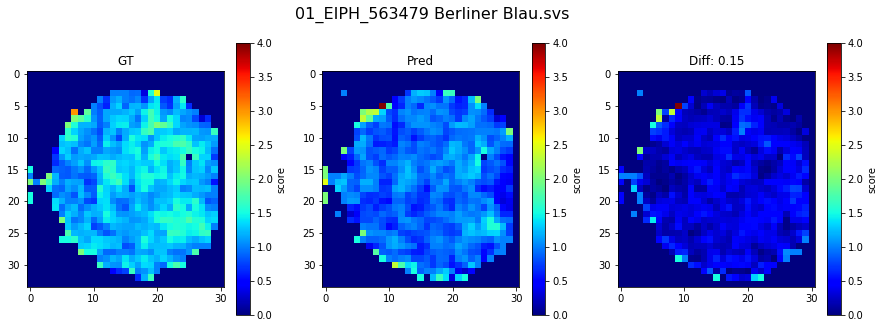

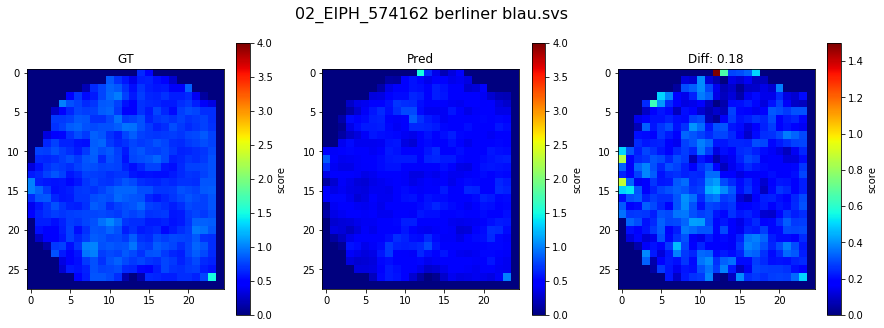

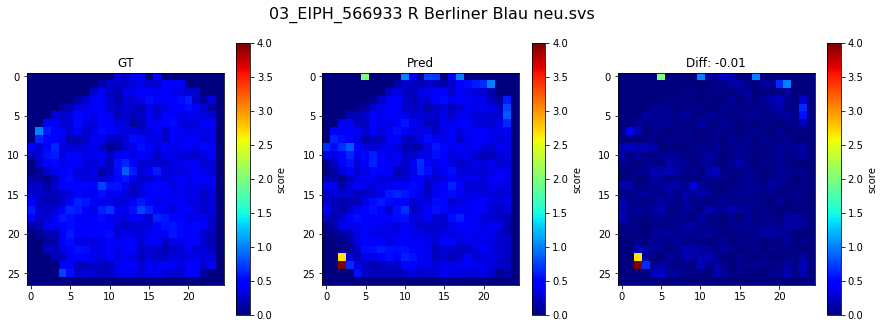

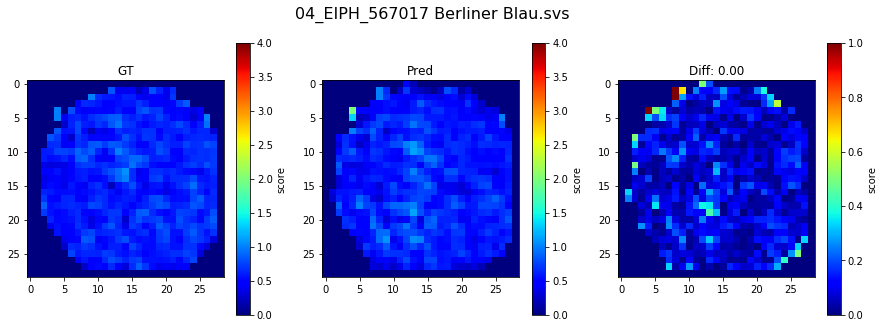

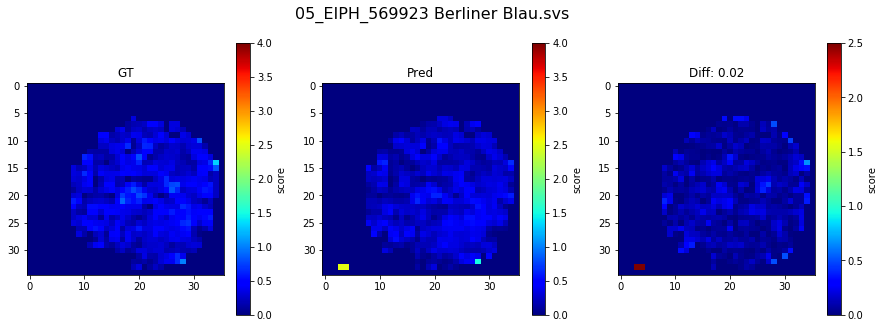

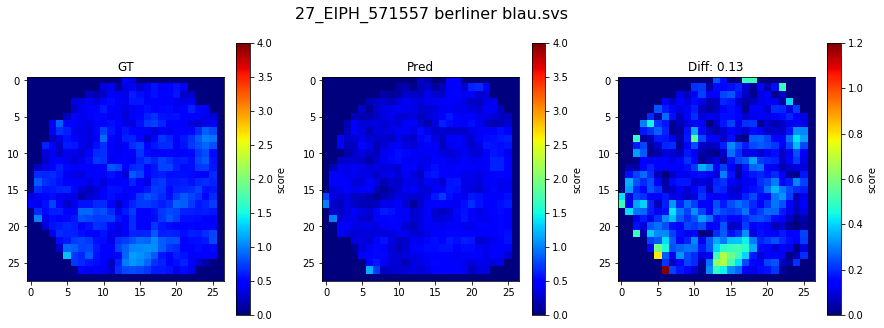

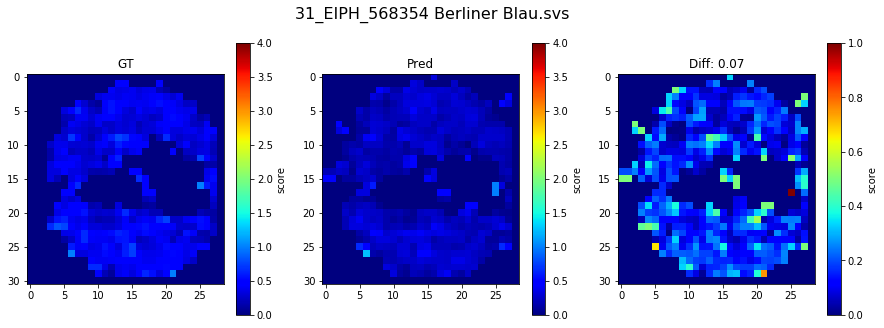

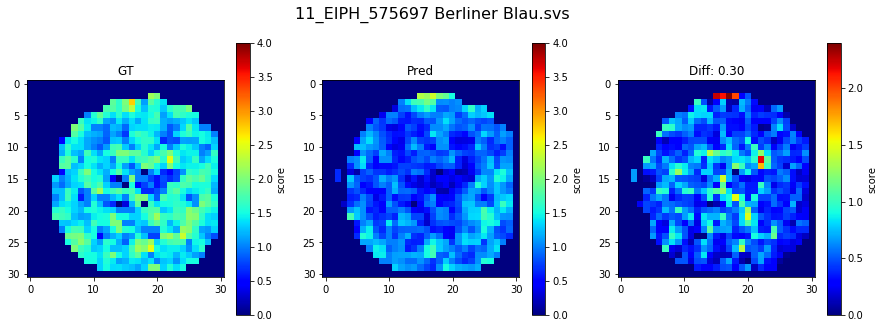

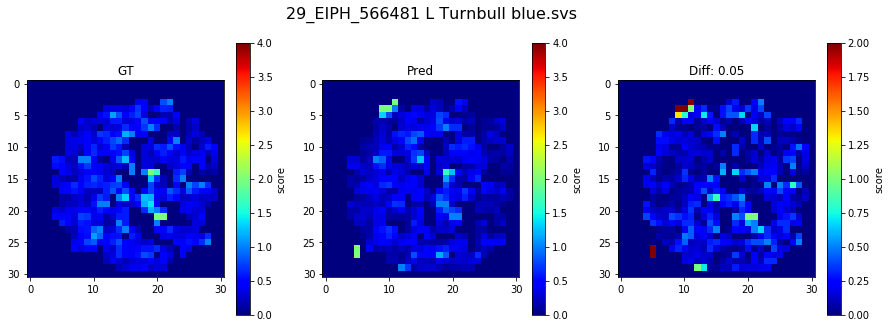

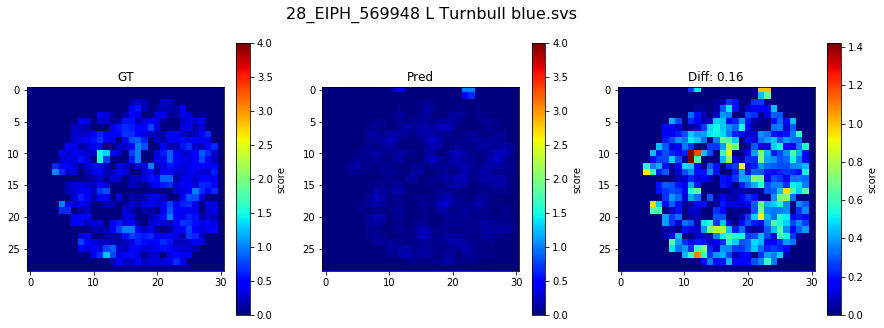

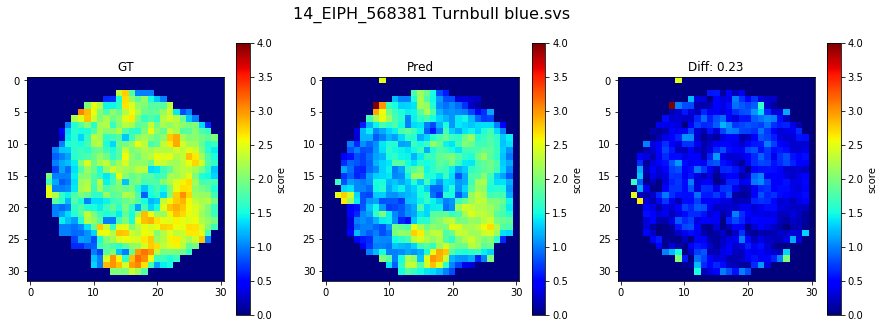

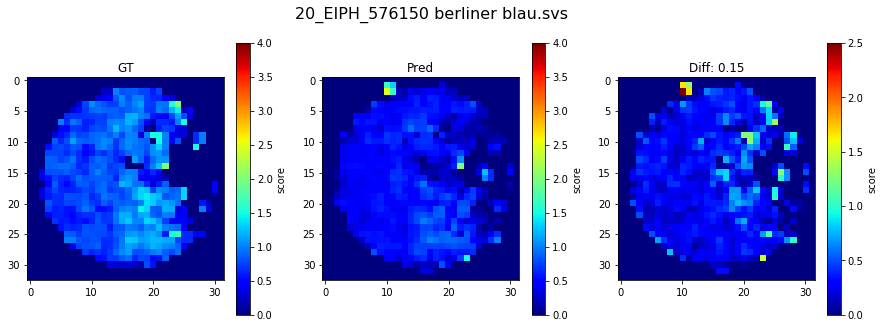

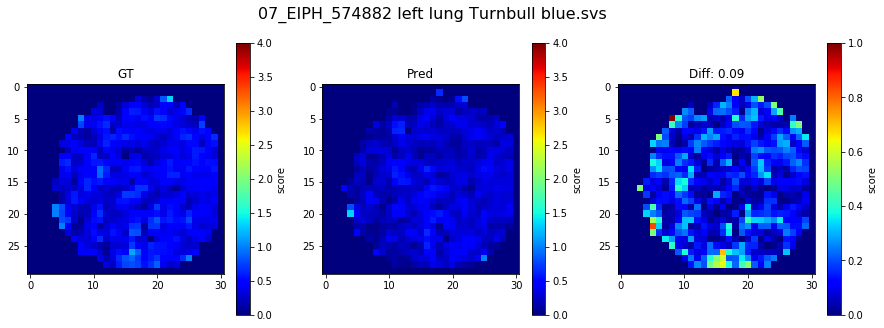

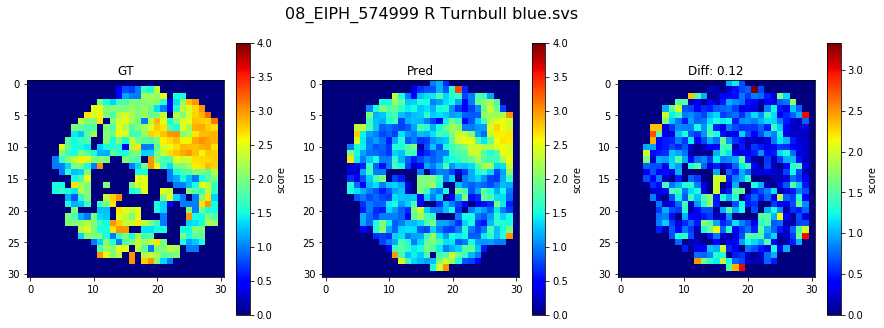

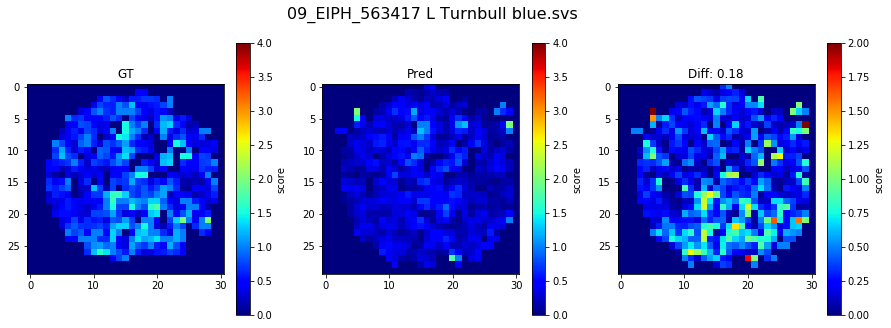

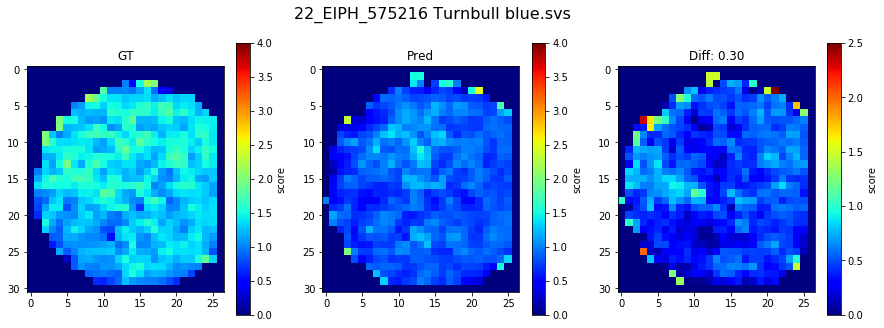

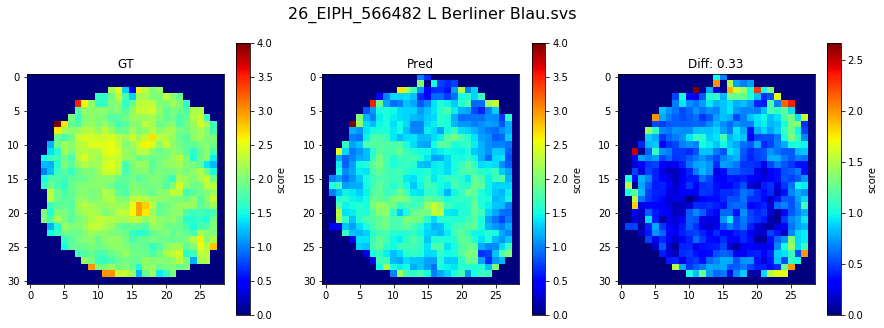

In [98]:
for file in files:
    pred_image = prediction[file.file.name]
    gt_image = gt[file.file.name]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(file.file.name, fontsize=16)

    diff = np.mean(gt_image - pred_image)
    ax[0].set_title('GT')
    ax[1].set_title('Pred')
    ax[2].set_title('Diff: {0:.2f}'.format(float(diff)))
    
    max_value = 4#np.max(gt_image)
    cset0 = ax[0].imshow(gt_image,  cmap=cm.jet, vmin=0, vmax=max_value)
    cset1 = ax[1].imshow(pred_image,  cmap=cm.jet, vmin=0, vmax=max_value)
    cset2 = ax[2].imshow(np.abs(pred_image-gt_image),  cmap=cm.jet, vmin=0)
    
    fig.colorbar(cset0, ax=ax[0], label='score')
    fig.colorbar(cset1, ax=ax[1], label='score')
    fig.colorbar(cset2, ax=ax[2], label='score')